**Preparation**

Run the next 4 code blocks before Experiment #1 and Experiment #2

In [2]:
import urllib.request
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential, model_from_json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [3]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.5.0


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
try:
  urllib.request.urlretrieve ("https://raw.githubusercontent.com/whittlem/colabnotebooks/main/datasets/btc-gbp-3600.csv", "btc-gbp-3600.csv")
  print('Success: downloaded btc-gbp-3600.csv.')
except Exception as e:
  print('Data load error: ',e)
try:
  df = pd.read_csv('./btc-gbp-3600.csv', index_col=0)
  print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: downloaded btc-gbp-3600.csv.
Success: Data loaded into dataframe.


In [6]:
df.shape

(29981, 73)

In [7]:
print (f'{df.shape[0] / 24} days of hourly trading data!')

1249.2083333333333 days of hourly trading data!


**Experiment #1**

* Single input
* Single output

In [8]:
df.head()

,market,granularity,low,high,open,close,volume,close_pc,close_cpc,cma,sma20,sma50,sma200,ema8,ema12,ema26,goldencross,deathcross,fbb_mid,fbb_upper0_236,fbb_upper0_382,fbb_upper0_5,fbb_upper0_618,fbb_upper0_764,fbb_upper1,fbb_lower0_236,fbb_lower0_382,fbb_lower0_5,fbb_lower0_618,fbb_lower0_764,fbb_lower1,rsi14,macd,signal,obv,obv_pc,ema13,elder_ray_bull,elder_ray_bear,eri_buy,eri_sell,ema8gtema12,ema8gtema12co,ema8ltema12,ema8ltema12co,ema12gtema26,ema12gtema26co,ema12ltema26,ema12ltema26co,sma50gtsma200,sma50gtsma200co,sma50ltsma200,sma50ltsma200co,macdgtsignal,macdgtsignalco,macdltsignal,macdltsignalco,astral_buy,astral_sell,hammer,inverted_hammer,shooting_star,hanging_man,three_white_soldiers,three_black_crows,doji,three_line_strike,two_black_gapping,morning_star,evening_star,abandoned_baby,morning_doji_star,evening_doji_star
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-07 09:00:00,BTC-GBP,3600,12399.70,12524.87,12503.74,12437.04,10.807921,0.000000,1.000000,12437.040000,12437.040000,12437.040000,12437.040000,12437.040000,12437.040000,12437.040000,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.000000,0.000000,10.807921,0.00,12437.040000,87.830000,-37.340000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2018-01-07 10:00:00,BTC-GBP,3600,12403.08,12505.42,12437.04,12486.08,12.968296,0.003943,1.003943,12461.560000,12461.560000,12461.560000,12461.560000,12447.937778,12444.584615,12440.672593,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,3.912023,0.782405,23.776217,119.99,12444.045714,61.374286,-40.965714,False,True,True,True,False,False,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2018-01-07 11:00:00,BTC-GBP,3600,12430.00,12546.82,12486.08,12437.10,20.277987,-0.003923,1.000005,12453.406667,12453.406667,12453.406667,12453.406667,12445.529383,12443.433136,12440.407956,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,3.025180,1.230960,3.498230,-85.29,12443.053469,103.766531,-13.053469,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2018-01-07 12:00:00,BTC-GBP,3600,12261.00,12450.62,12430.00,12299.99,23.184213,-0.011024,0.988980,12415.052500,12415.052500,12415.052500,12415.052500,12413.187298,12421.364961,12430.006626,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,-8.641665,-0.743565,-19.685983,-662.74,12422.615831,28.004169,-161.615831,False,True,False,False,True,True,False,False,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2018-01-07 13:00:00,BTC-GBP,3600,12250.00,12357.14,12299.98,12310.09,15.635170,0.000821,0.989793,12394.060000,12394.060000,12394.060000,12394.060000,12390.276787,12404.245736,12421.123913,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,-16.878176,-3.970487,-4.050814,-79.42,12406.540712,-49.400712,-156.540712,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [ ]:
df['next_close'] = df['close'].shift(-1) > df['close'] # 1 if next close is higher, else 0
df.loc[df['close'].shift(-1) < df['close'], 'next_close'] = -1
df['next_close'] = df['next_close'].astype(int) # 1 for up, 0 for hold, -1 for down
df = df[:-1]

df['next_close'].value_counts()

 1    15176
-1    14738
 0       66
Name: next_close, dtype: int64

In [ ]:
df1 = df[[ 'close_cpc', 'next_close' ]]

In [ ]:
df1.head()

,close_cpc,next_close
date,,
2018-01-07 09:00:00,1.000000,1
2018-01-07 10:00:00,1.003943,-1
2018-01-07 11:00:00,1.000005,-1
2018-01-07 12:00:00,0.988980,1
2018-01-07 13:00:00,0.989793,1


In [ ]:
X = df1['close_cpc'] # input
y = df1['next_close'] # target

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22485,), (7495,), (22485,), (7495,))

In [ ]:
# create the sequential model
network = Sequential()

In [ ]:
activation = 'tanh'

# create the structure of the neural network
network.add(Dense(1, input_shape=(1,), activation=activation))
network.add(Dense(3, activation=activation))
network.add(Dense(3, activation=activation))
network.add(Dense(3, activation=activation))
network.add(Dense(1, activation=activation))

In [ ]:
# compile the model
if activation == 'tanh':
    network.compile(optimizer='rmsprop', loss='hinge', metrics=['accuracy'])
elif activation == 'relu':
    #network.compile(optimizer='adam', loss='mse')
    network.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model
network.fit(X_train.values, y_train.values, epochs=100, batch_size=24, validation_data=(X_test.values, y_test.values), verbose=1, callbacks=[], shuffle=False)

Epoch 1/100
937/937 [==============================] - 3s 2ms/step - loss: 1.0016 - accuracy: 0.0024 - val_loss: 0.9965 - val_accuracy: 0.0017
Epoch 2/100
937/937 [==============================] - 1s 2ms/step - loss: 0.9972 - accuracy: 0.0024 - val_loss: 0.9902 - val_accuracy: 0.0017
Epoch 3/100
937/937 [==============================] - 1s 2ms/step - loss: 0.9933 - accuracy: 0.1749 - val_loss: 0.9842 - val_accuracy: 0.5121
Epoch 4/100
937/937 [==============================] - 1s 2ms/step - loss: 0.9895 - accuracy: 0.5071 - val_loss: 0.9795 - val_accuracy: 0.5121
Epoch 5/100
937/937 [==============================] - 1s 2ms/step - loss: 0.9866 - accuracy: 0.5071 - val_loss: 0.9768 - val_accuracy: 0.5121
Epoch 6/100
937/937 [==============================] - 1s 2ms/step - loss: 0.9850 - accuracy: 0.5071 - val_loss: 0.9755 - val_accuracy: 0.5121
Epoch 7/100
937/937 [==============================] - 1s 2ms/step - loss: 0.9842 - accuracy: 0.5071 - val_loss: 0.9748 - val_accuracy: 0.5121

In [ ]:
# evaluate the predictions of the model
y_pred = network.predict(X_test.values)
y_pred = np.around(y_pred, 0)

In [ ]:
# classification performance report
print(classification_report(y_test, y_pred))  

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      3644
           0       0.00      0.00      0.00        13
           1       0.51      1.00      0.68      3838

    accuracy                           0.51      7495
   macro avg       0.17      0.33      0.23      7495
weighted avg       0.26      0.51      0.35      7495



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Experiment #2**

* Multiple inputs
* Single output

In [ ]:
df2 = df[[ 'volume', 'close_cpc', 'next_close' ]]

In [ ]:
df2.head()

,volume,close_cpc,next_close
date,,,
2018-01-07 09:00:00,10.807921,1.000000,1
2018-01-07 10:00:00,12.968296,1.003943,-1
2018-01-07 11:00:00,20.277987,1.000005,-1
2018-01-07 12:00:00,23.184213,0.988980,1
2018-01-07 13:00:00,15.635170,0.989793,1


In [ ]:
# initialise scaler
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
# scale our features
df_scaled = pd.DataFrame(scaler.fit_transform(df[[ 'volume', 'close_cpc', 'next_close' ]].values))
df_scaled.columns = [ 'volume', 'close_cpc', 'next_close' ]

In [ ]:
df_scaled.head()

,volume,close_cpc,next_close
0,0.007059,0.223056,1.0
1,0.008474,0.224158,0.0
2,0.013262,0.223057,0.0
3,0.015166,0.219977,1.0
4,0.010221,0.220204,1.0


In [ ]:
X = df_scaled[[ 'volume', 'close_cpc' ]]
y = df_scaled[[ 'next_close' ]]

In [ ]:
X.shape, y.shape

((29980, 2), (29980, 1))

In [ ]:
def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

In [ ]:
window = 4
df_window = create_window(X, window)

In [ ]:
df_window.shape

(29976, 10)

In [ ]:
df_window.head()

,volume,close_cpc,volume,close_cpc,volume,close_cpc,volume,close_cpc,volume,close_cpc
0,0.007059,0.223056,0.008474,0.224158,0.013262,0.223057,0.015166,0.219977,0.010221,0.220204
1,0.008474,0.224158,0.013262,0.223057,0.015166,0.219977,0.010221,0.220204,0.011563,0.222198
2,0.013262,0.223057,0.015166,0.219977,0.010221,0.220204,0.011563,0.222198,0.010830,0.220690
3,0.015166,0.219977,0.010221,0.220204,0.011563,0.222198,0.010830,0.220690,0.022441,0.213547
4,0.010221,0.220204,0.011563,0.222198,0.010830,0.220690,0.022441,0.213547,0.020416,0.210606


In [ ]:
X_df_window = np.reshape(df_window.values, (df_window.shape[0], window+1, len(X.columns)))

In [ ]:
print (X_df_window.shape)
print (df_window.iloc[:window,:])
print (X_df_window[0,:,:])

(29976, 5, 2)
     volume  close_cpc    volume  ...  close_cpc    volume  close_cpc
0  0.007059   0.223056  0.008474  ...   0.219977  0.010221   0.220204
1  0.008474   0.224158  0.013262  ...   0.220204  0.011563   0.222198
2  0.013262   0.223057  0.015166  ...   0.222198  0.010830   0.220690
3  0.015166   0.219977  0.010221  ...   0.220690  0.022441   0.213547

[4 rows x 10 columns]
[[0.00705945 0.22305596]
 [0.00847448 0.22415754]
 [0.01326226 0.22305731]
 [0.01516582 0.21997745]
 [0.01022126 0.22020432]]


In [ ]:
y_df_window = np.array(df_scaled['next_close'][window:])

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22485, 2), (7495, 2), (22485, 1), (7495, 1))

In [ ]:
def model_lstm (window, features):    
    # create the sequential model
    model = Sequential()

    # create the structure of the neural network
    model.add(LSTM(300, input_shape=(window, features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200, input_shape=(window, features), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(100, kernel_initializer='uniform', activation='relu'))        
    model.add(Dense(1, kernel_initializer='uniform', activation='relu'))

    # compile the model
    model.compile(loss='mse', optimizer='adam')

    return model

In [ ]:
# create model
model = model_lstm(window+1, len(X.columns))

In [ ]:
# fit the model
model.fit(X_train, y_train, epochs=100, batch_size=24, validation_data=(X_test, y_test), verbose=1, callbacks=[], shuffle=False)

Epoch 1/100


ValueError: ignored

In [ ]:
# evaluate the predictions of the model
y_pred = network.predict(X_test.values)
y_pred = np.around(y_pred, 0)

ValueError: ignored

In [ ]:
# classification performance report
print(classification_report(y_test, y_pred))

ValueError: ignored

**Experiment #3**

In [9]:
df.head()

,market,granularity,low,high,open,close,volume,close_pc,close_cpc,cma,sma20,sma50,sma200,ema8,ema12,ema26,goldencross,deathcross,fbb_mid,fbb_upper0_236,fbb_upper0_382,fbb_upper0_5,fbb_upper0_618,fbb_upper0_764,fbb_upper1,fbb_lower0_236,fbb_lower0_382,fbb_lower0_5,fbb_lower0_618,fbb_lower0_764,fbb_lower1,rsi14,macd,signal,obv,obv_pc,ema13,elder_ray_bull,elder_ray_bear,eri_buy,eri_sell,ema8gtema12,ema8gtema12co,ema8ltema12,ema8ltema12co,ema12gtema26,ema12gtema26co,ema12ltema26,ema12ltema26co,sma50gtsma200,sma50gtsma200co,sma50ltsma200,sma50ltsma200co,macdgtsignal,macdgtsignalco,macdltsignal,macdltsignalco,astral_buy,astral_sell,hammer,inverted_hammer,shooting_star,hanging_man,three_white_soldiers,three_black_crows,doji,three_line_strike,two_black_gapping,morning_star,evening_star,abandoned_baby,morning_doji_star,evening_doji_star
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-07 09:00:00,BTC-GBP,3600,12399.70,12524.87,12503.74,12437.04,10.807921,0.000000,1.000000,12437.040000,12437.040000,12437.040000,12437.040000,12437.040000,12437.040000,12437.040000,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.000000,0.000000,10.807921,0.00,12437.040000,87.830000,-37.340000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2018-01-07 10:00:00,BTC-GBP,3600,12403.08,12505.42,12437.04,12486.08,12.968296,0.003943,1.003943,12461.560000,12461.560000,12461.560000,12461.560000,12447.937778,12444.584615,12440.672593,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,3.912023,0.782405,23.776217,119.99,12444.045714,61.374286,-40.965714,False,True,True,True,False,False,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2018-01-07 11:00:00,BTC-GBP,3600,12430.00,12546.82,12486.08,12437.10,20.277987,-0.003923,1.000005,12453.406667,12453.406667,12453.406667,12453.406667,12445.529383,12443.433136,12440.407956,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,3.025180,1.230960,3.498230,-85.29,12443.053469,103.766531,-13.053469,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2018-01-07 12:00:00,BTC-GBP,3600,12261.00,12450.62,12430.00,12299.99,23.184213,-0.011024,0.988980,12415.052500,12415.052500,12415.052500,12415.052500,12413.187298,12421.364961,12430.006626,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,-8.641665,-0.743565,-19.685983,-662.74,12422.615831,28.004169,-161.615831,False,True,False,False,True,True,False,False,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2018-01-07 13:00:00,BTC-GBP,3600,12250.00,12357.14,12299.98,12310.09,15.635170,0.000821,0.989793,12394.060000,12394.060000,12394.060000,12394.060000,12390.276787,12404.245736,12421.123913,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,-16.878176,-3.970487,-4.050814,-79.42,12406.540712,-49.400712,-156.540712,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [11]:
df['date'] = df.index
df3 = df[[ 'date', 'open', 'high', 'low', 'close', 'volume' ]]
df3['volume'].replace(to_replace=0, method='ffill', inplace=True)
df3 = df3.reset_index(drop=True)
df3.sort_values('date', inplace=True)
df3.head()

,date,open,high,low,close,volume
0,2018-01-07 09:00:00,12503.74,12524.87,12399.70,12437.04,10.807921
1,2018-01-07 10:00:00,12437.04,12505.42,12403.08,12486.08,12.968296
2,2018-01-07 11:00:00,12486.08,12546.82,12430.00,12437.10,20.277987
3,2018-01-07 12:00:00,12430.00,12450.62,12261.00,12299.99,23.184213
4,2018-01-07 13:00:00,12299.98,12357.14,12250.00,12310.09,15.635170


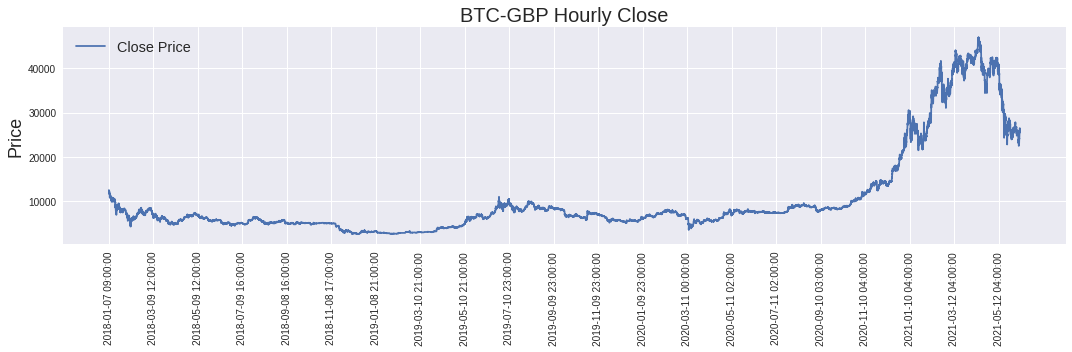

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(df3['close'])
plt.xticks(range(0, df3.shape[0], 1464), df3['date'].loc[::1464], rotation=90)
plt.ylabel('Price', fontsize=18)
plt.title("BTC-GBP Hourly Close", fontsize=20)
plt.legend(['Close Price'], fontsize='x-large', loc='best')
plt.tight_layout()
plt.show()

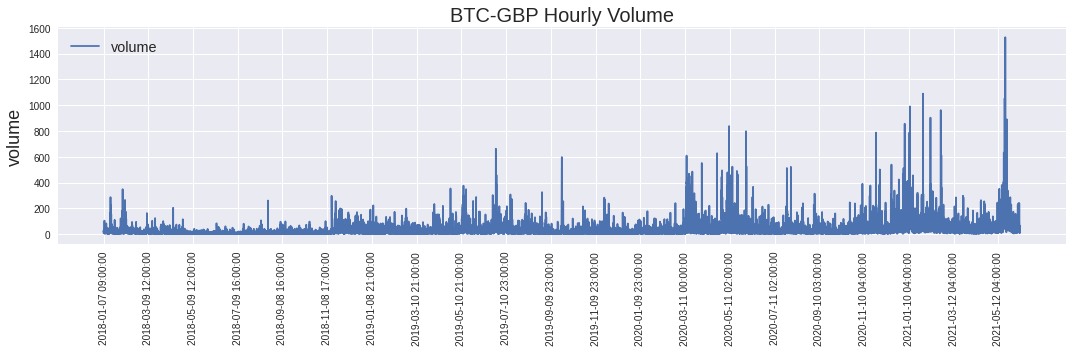

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(df3['volume'])
plt.xticks(range(0, df3.shape[0], 1464), df3['date'].loc[::1464], rotation=90)
plt.ylabel('volume', fontsize=18)
plt.title("BTC-GBP Hourly Volume", fontsize=20)
plt.legend(['volume'], fontsize='x-large', loc='best')
plt.tight_layout()
plt.show()

In [15]:
# calculate percentage change
df3['open'] = df3['open'].pct_change()
df3['high'] = df3['high'].pct_change()
df3['low'] = df3['low'].pct_change()
df3['close'] = df3['close'].pct_change()
df3['volume'] = df3['volume'].pct_change()

df3.dropna(how='any', axis=0, inplace=True)

In [16]:
df3.head()

,date,open,high,low,close,volume
1,2018-01-07 10:00:00,-0.005334,-0.001553,0.000273,0.003943,0.199888
2,2018-01-07 11:00:00,0.003943,0.003311,0.002170,-0.003923,0.563659
3,2018-01-07 12:00:00,-0.004491,-0.007667,-0.013596,-0.011024,0.143319
4,2018-01-07 13:00:00,-0.010460,-0.007508,-0.000897,0.000821,-0.325611
5,2018-01-07 14:00:00,0.000783,0.003468,0.002613,0.007210,0.131067


In [17]:
# normalize price columns
min_return = min(df3[['open', 'high', 'low', 'close']].min(axis=0))
max_return = max(df3[['open', 'high', 'low', 'close']].max(axis=0))

# min-max normalize price columns (0-1 range)
df3['open'] = (df3['open'] - min_return) / (max_return - min_return)
df3['high'] = (df3['high'] - min_return) / (max_return - min_return)
df3['low'] = (df3['low'] - min_return) / (max_return - min_return)
df3['close'] = (df3['close'] - min_return) / (max_return - min_return)

In [18]:
df3.head()

,date,open,high,low,close,volume
1,2018-01-07 10:00:00,0.503631,0.512297,0.516481,0.524893,0.199888
2,2018-01-07 11:00:00,0.524893,0.523443,0.520831,0.506866,0.563659
3,2018-01-07 12:00:00,0.505563,0.498285,0.484697,0.490591,0.143319
4,2018-01-07 13:00:00,0.491884,0.498650,0.513800,0.517738,-0.325611
5,2018-01-07 14:00:00,0.517651,0.523805,0.521845,0.532381,0.131067


In [19]:
# normalize volume column
min_volume = df3['volume'].min(axis=0)
max_volume = df3['volume'].max(axis=0)

# min-max normalize volume columns (0-1 range)
df3['volume'] = (df3['volume'] - min_volume) / (max_volume - min_volume)

In [20]:
df3.head()

,date,open,high,low,close,volume
1,2018-01-07 10:00:00,0.503631,0.512297,0.516481,0.524893,0.017565
2,2018-01-07 11:00:00,0.524893,0.523443,0.520831,0.506866,0.022911
3,2018-01-07 12:00:00,0.505563,0.498285,0.484697,0.490591,0.016734
4,2018-01-07 13:00:00,0.491884,0.498650,0.513800,0.517738,0.009843
5,2018-01-07 14:00:00,0.517651,0.523805,0.521845,0.532381,0.016554


In [21]:
# create training, validation and test split
times = sorted(df3.index.values)
last_10pct = sorted(df3.index.values)[-int(0.1*len(times))] # last 10% of series
last_20pct = sorted(df3.index.values)[-int(0.2*len(times))] # last 20% of series

df3_train = df3[(df3.index < last_20pct)] # training data is 80% of total
df3_val = df3[(df3.index >= last_20pct) & (df3.index < last_10pct)]
df3_test = df3[(df3.index >= last_10pct)]

# Remove date column
df3_train.drop(columns=['date'], inplace=True)
df3_val.drop(columns=['date'], inplace=True)
df3_test.drop(columns=['date'], inplace=True)

# Convert pandas columns into arrays
train_data = df3_train.values
val_data = df3_val.values
test_data = df3_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (23984, 5)
Validation data shape: (2998, 5)
Test data shape: (2998, 5)


In [22]:
df3_train.head()

,open,high,low,close,volume
1,0.503631,0.512297,0.516481,0.524893,0.017565
2,0.524893,0.523443,0.520831,0.506866,0.022911
3,0.505563,0.498285,0.484697,0.490591,0.016734
4,0.491884,0.498650,0.513800,0.517738,0.009843
5,0.517651,0.523805,0.521845,0.532381,0.016554


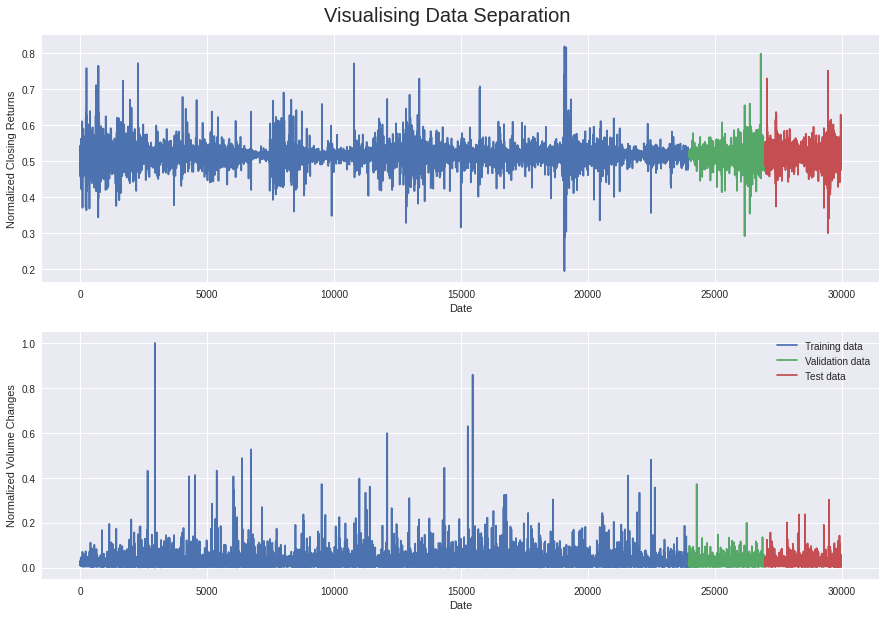

In [23]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Visualising Data Separation", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df3_train['close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], train_data.shape[0]+val_data.shape[0]), df3_val['close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df3_test['close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df3_train['volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], train_data.shape[0]+val_data.shape[0]), df3_val['volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df3_test['volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')

plt.legend(loc='best')

In [24]:
# hyperparameter
seq_len = 128

# training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # window of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) # value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

# validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

# test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(23856, 128, 5) (23856,)
(2870, 128, 5) (2870,)


In [25]:
# 1D convolution layers for a CNN+LSTM model

def Inception_A(layer_in, c7):
  branch1x1_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch1x1 = BatchNormalization()(branch1x1_1)
  branch1x1 = ReLU()(branch1x1)
  
  branch5x5_1 = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(layer_in)
  branch5x5 = BatchNormalization()(branch5x5_1)
  branch5x5 = ReLU()(branch5x5)
  branch5x5 = Conv1D(c7, kernel_size=5, padding='same', use_bias=False)(branch5x5)
  branch5x5 = BatchNormalization()(branch5x5)
  branch5x5 = ReLU()(branch5x5)  
  
  branch3x3_1 = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(layer_in)
  branch3x3 = BatchNormalization()(branch3x3_1)
  branch3x3 = ReLU()(branch3x3)
  branch3x3 = Conv1D(c7, kernel_size=3, padding='same', use_bias=False)(branch3x3)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3)
  branch3x3 = Conv1D(c7, kernel_size=3, padding='same', use_bias=False)(branch3x3)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3) 
  
  branch_pool = AveragePooling1D(pool_size=(3), strides=1, padding='same')(layer_in)
  branch_pool = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(branch_pool)
  branch_pool = BatchNormalization()(branch_pool)
  branch_pool = ReLU()(branch_pool)
  outputs = Concatenate(axis=-1)([branch1x1, branch5x5, branch3x3, branch_pool])
  return outputs


def Inception_B(layer_in, c7):
  branch3x3 = Conv1D(c7, kernel_size=3, padding="same", strides=2, use_bias=False)(layer_in)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3)  
  
  branch3x3dbl = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)  
  branch3x3dbl = Conv1D(c7, kernel_size=3, padding="same", use_bias=False)(branch3x3dbl)  
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)  
  branch3x3dbl = Conv1D(c7, kernel_size=3, padding="same", strides=2, use_bias=False)(branch3x3dbl)    
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)   
  
  branch_pool = MaxPooling1D(pool_size=3, strides=2, padding="same")(layer_in)
  
  outputs = Concatenate(axis=-1)([branch3x3, branch3x3dbl, branch_pool])
  return outputs


def Inception_C(layer_in, c7):
  branch1x1_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch1x1 = BatchNormalization()(branch1x1_1)
  branch1x1 = ReLU()(branch1x1)   
  
  branch7x7_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch7x7 = BatchNormalization()(branch7x7_1)
  branch7x7 = ReLU()(branch7x7)   
  branch7x7 = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7)
  branch7x7 = BatchNormalization()(branch7x7)
  branch7x7 = ReLU()(branch7x7)  
  branch7x7 = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7)  
  branch7x7 = BatchNormalization()(branch7x7)
  branch7x7 = ReLU()(branch7x7)   

  branch7x7dbl_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl_1)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  branch7x7dbl = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl) 
  branch7x7dbl = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  branch7x7dbl = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  branch7x7dbl = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  
  branch_pool = AveragePooling1D(pool_size=3, strides=1, padding='same')(layer_in)
  branch_pool = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(branch_pool)
  branch_pool = BatchNormalization()(branch_pool)
  branch_pool = ReLU()(branch_pool)  
  
  outputs = Concatenate(axis=-1)([branch1x1, branch7x7, branch7x7dbl, branch_pool])
  return outputs

**Bi-LSTM model**

In [26]:
def create_model():
  in_seq = Input(shape=(seq_len, 5))
      
  x = Bidirectional(LSTM(128, return_sequences=True))(in_seq)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="linear")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])    
  return model

model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 5)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 128, 256)     137216      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 128, 256)     394240      bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 128, 128)     164352      bidirectional_1[0][0]            
______________________________________________________________________________________________

In [27]:
callback = tf.keras.callbacks.ModelCheckpoint('Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

In [28]:
model.fit(X_train, y_train,
              batch_size=2048,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),) 

Epoch 1/200
12/12 - 19s - loss: 0.0246 - mae: 0.1076 - mape: 20.8900 - val_loss: 0.0014 - val_mae: 0.0326 - val_mape: 6.4448

Epoch 00001: val_loss improved from inf to 0.00142, saving model to Bi-LSTM.hdf5
Epoch 2/200
12/12 - 4s - loss: 0.0015 - mae: 0.0323 - mape: 6.2748 - val_loss: 0.0014 - val_mae: 0.0330 - val_mape: 6.5366

Epoch 00002: val_loss did not improve from 0.00142
Epoch 3/200
12/12 - 4s - loss: 7.2480e-04 - mae: 0.0203 - mape: 3.9621 - val_loss: 5.4402e-04 - val_mae: 0.0161 - val_mape: 3.1090

Epoch 00003: val_loss improved from 0.00142 to 0.00054, saving model to Bi-LSTM.hdf5
Epoch 4/200
12/12 - 4s - loss: 4.7019e-04 - mae: 0.0141 - mape: 2.7648 - val_loss: 5.8040e-04 - val_mae: 0.0171 - val_mape: 3.2935

Epoch 00004: val_loss did not improve from 0.00054
Epoch 5/200
12/12 - 4s - loss: 4.2335e-04 - mae: 0.0124 - mape: 2.4246 - val_loss: 4.8970e-04 - val_mae: 0.0144 - val_mape: 2.8107

Epoch 00005: val_loss improved from 0.00054 to 0.00049, saving model to Bi-LSTM.hdf5
E

In [46]:
!ls

Bi-LSTM.hdf5  btc-gbp-3600.csv	CNN+Bi-LSTM.hdf5  sample_data


In [33]:
from google.colab import files
files.download('/content/Bi-LSTM.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
model = tf.keras.models.load_model('/content/Bi-LSTM.hdf5')

In [30]:
# calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)

print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Evaluation metrics
Training Data - Loss: 0.0004, MAE: 0.0110, MAPE: 2.1527
Validation Data - Loss: 0.0005, MAE: 0.0142, MAPE: 2.7753
Test Data - Loss: 0.0006, MAE: 0.0161, MAPE: 3.1609


In [36]:
X_train

array([[[0.50363107, 0.51229744, 0.51648108, 0.524893  , 0.01756495],
        [0.524893  , 0.52344346, 0.52083052, 0.50686624, 0.02291058],
        [0.50556305, 0.49828463, 0.48469698, 0.49059113, 0.01673367],
        ...,
        [0.52691879, 0.51533855, 0.49292524, 0.46282458, 0.02089511],
        [0.4630495 , 0.47566084, 0.47698229, 0.50632391, 0.01217111],
        [0.508691  , 0.5102984 , 0.52968968, 0.5212862 , 0.01258155]],

       [[0.524893  , 0.52344346, 0.52083052, 0.50686624, 0.02291058],
        [0.50556305, 0.49828463, 0.48469698, 0.49059113, 0.01673367],
        [0.49188392, 0.49864953, 0.51380029, 0.51773824, 0.00984271],
        ...,
        [0.4630495 , 0.47566084, 0.47698229, 0.50632391, 0.01217111],
        [0.508691  , 0.5102984 , 0.52968968, 0.5212862 , 0.01258155],
        [0.51864999, 0.50011305, 0.50713537, 0.49463393, 0.01503645]],

       [[0.50556305, 0.49828463, 0.48469698, 0.49059113, 0.01673367],
        [0.49188392, 0.49864953, 0.51380029, 0.51773824, 0.0

In [37]:
train_pred

array([[0.51526237],
       [0.51521975],
       [0.51514   ],
       ...,
       [0.51600045],
       [0.51600677],
       [0.5160103 ]], dtype=float32)

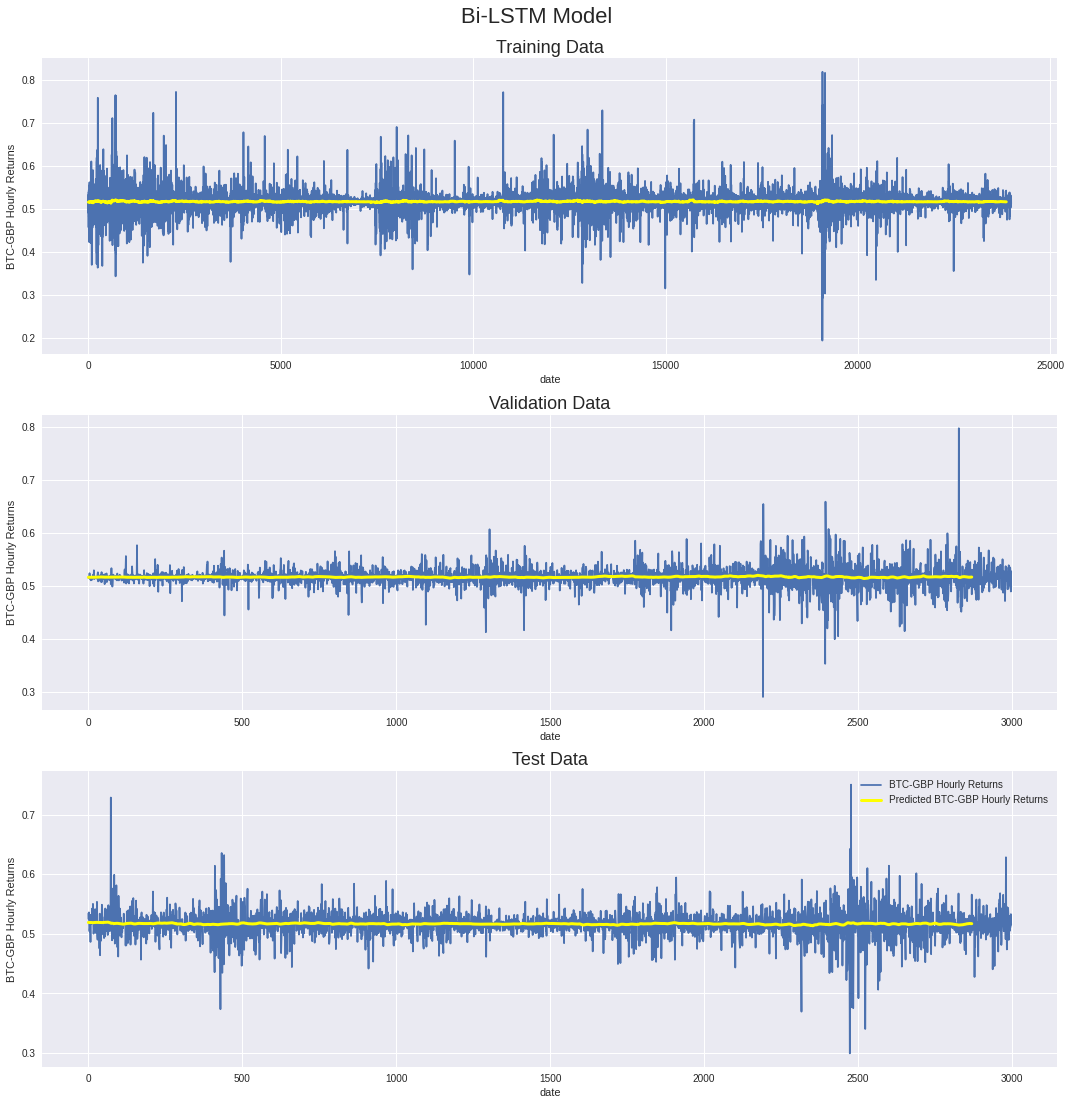

In [31]:
# display results
fig = plt.figure(figsize=(15,15))
st = fig.suptitle("Bi-LSTM Model", fontsize=22)
st.set_y(1.02)

# plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='BTC-GBP Hourly Returns')
ax11.plot(train_pred, color='yellow', linewidth=3, label='Predicted BTC-GBP Hourly Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('date')
ax11.set_ylabel('BTC-GBP Hourly Returns')

# plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='BTC-GBP Hourly Returns')
ax21.plot(val_pred, color='yellow', linewidth=3, label='Predicted BTC-GBP Hourly Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('date')
ax21.set_ylabel('BTC-GBP Hourly Returns')

# plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='BTC-GBP Hourly Returns')
ax31.plot(test_pred, color='yellow', linewidth=3, label='Predicted BTC-GBP Hourly Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('date')
ax31.set_ylabel('BTC-GBP Hourly Returns')

plt.tight_layout()
plt.legend(loc='best')

**CNN + Bi-LSTM model**

In [38]:
def create_model():
  in_seq = Input(shape=(seq_len, 5))

  x = Inception_A(in_seq, 32)
  x = Inception_A(x, 32)
  x = Inception_B(x, 32)
  x = Inception_B(x, 32)
  x = Inception_C(x, 32)
  x = Inception_C(x, 32)    
          
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])     
  return model

model = create_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 5)]     0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 128, 32)      160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 128, 32)      128         conv1d_3[0][0]                   
__________________________________________________________________________________________________
re_lu_3 (ReLU)                  (None, 128, 32)      0           batch_normalization_3[0][0]      
____________________________________________________________________________________________

In [39]:
callback = tf.keras.callbacks.ModelCheckpoint('CNN+Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

In [40]:
model.fit(X_train, y_train,
              batch_size=2048,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),)

Epoch 1/200
12/12 - 41s - loss: 0.0012 - mae: 0.0241 - mape: 4.6926 - val_loss: 6.0077e-04 - val_mae: 0.0176 - val_mape: 3.3742

Epoch 00001: val_loss improved from inf to 0.00060, saving model to CNN+Bi-LSTM.hdf5
Epoch 2/200
12/12 - 4s - loss: 4.3926e-04 - mae: 0.0130 - mape: 2.5387 - val_loss: 5.4003e-04 - val_mae: 0.0159 - val_mape: 3.0699

Epoch 00002: val_loss improved from 0.00060 to 0.00054, saving model to CNN+Bi-LSTM.hdf5
Epoch 3/200
12/12 - 4s - loss: 3.9816e-04 - mae: 0.0115 - mape: 2.2459 - val_loss: 5.4123e-04 - val_mae: 0.0160 - val_mape: 3.0759

Epoch 00003: val_loss did not improve from 0.00054
Epoch 4/200
12/12 - 4s - loss: 3.8953e-04 - mae: 0.0111 - mape: 2.1678 - val_loss: 5.2964e-04 - val_mae: 0.0156 - val_mape: 3.0151

Epoch 00004: val_loss improved from 0.00054 to 0.00053, saving model to CNN+Bi-LSTM.hdf5
Epoch 5/200
12/12 - 4s - loss: 3.8668e-04 - mae: 0.0110 - mape: 2.1584 - val_loss: 5.0564e-04 - val_mae: 0.0149 - val_mape: 2.8855

Epoch 00005: val_loss improve

In [41]:
model = tf.keras.models.load_model('/content/CNN+Bi-LSTM.hdf5')

In [42]:
# calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

# print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Evaluation metrics
Training Data - Loss: 0.0004, MAE: 0.0110, MAPE: 2.1619
Validation Data - Loss: 0.0005, MAE: 0.0142, MAPE: 2.7750
Test Data - Loss: 0.0006, MAE: 0.0160, MAPE: 3.1601


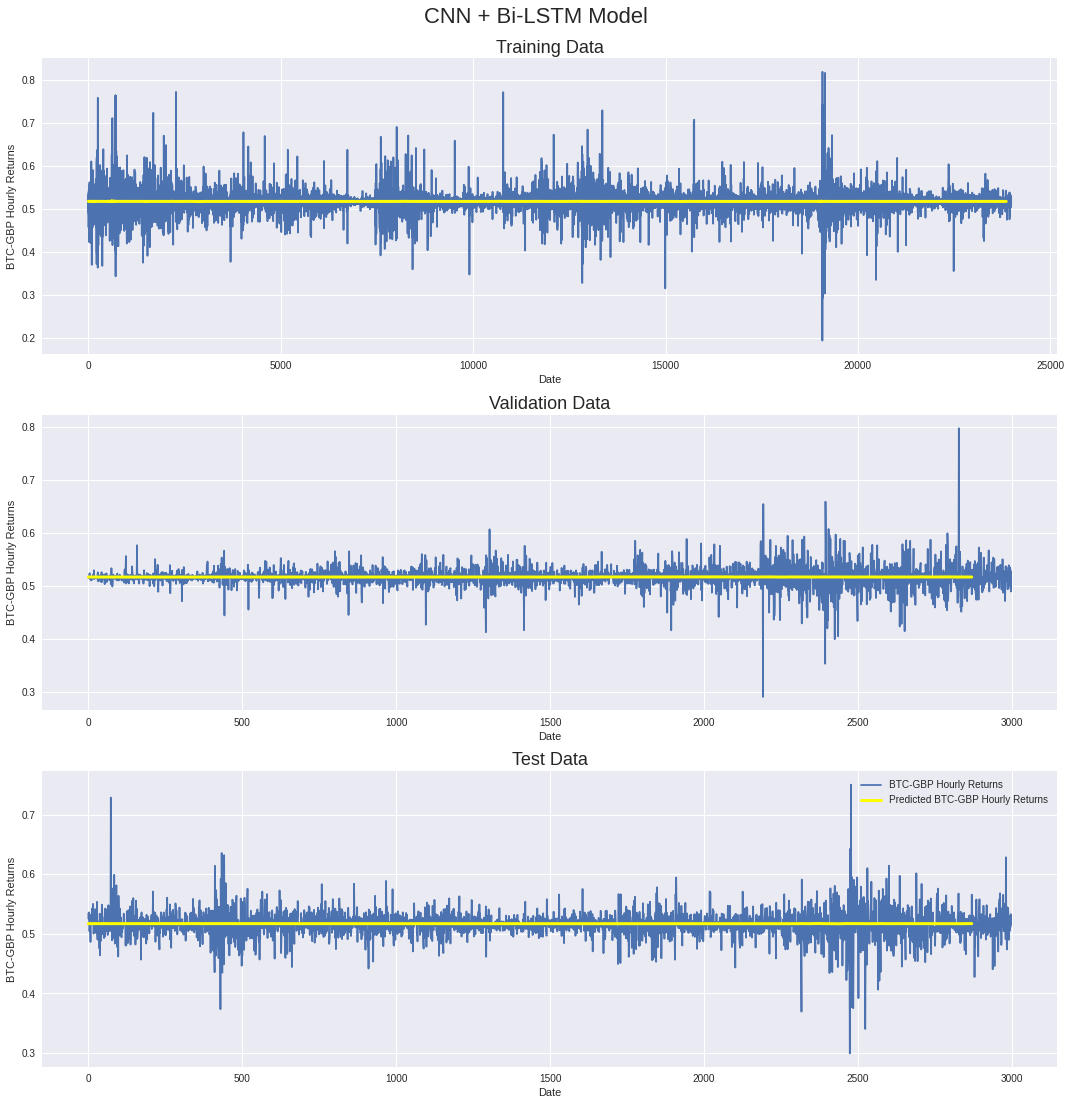

In [43]:
# display results
fig = plt.figure(figsize=(15,15))
st = fig.suptitle("CNN + Bi-LSTM Model", fontsize=22)
st.set_y(1.02)

# plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='BTC-GBP Hourly Returns')
ax11.plot(train_pred, color='yellow', linewidth=3, label='Predicted BTC-GBP Hourly Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC-GBP Hourly Returns')

# plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='BTC-GBP Hourly Returns')
ax21.plot(val_pred, color='yellow', linewidth=3, label='Predicted BTC-GBP Hourly Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('BTC-GBP Hourly Returns')

# plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='BTC-GBP Hourly Returns')
ax31.plot(test_pred, color='yellow', linewidth=3, label='Predicted BTC-GBP Hourly Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('BTC-GBP Hourly Returns')
 
plt.tight_layout()
plt.legend(loc='best')

In [44]:
!ls

Bi-LSTM.hdf5  btc-gbp-3600.csv	CNN+Bi-LSTM.hdf5  sample_data


In [45]:
from google.colab import files
files.download('/content/CNN+Bi-LSTM.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Moving Average - Bi-LSTM model**

In [47]:
def create_model():
  in_seq = Input(shape = (seq_len, 5))
      
  x = Bidirectional(LSTM(128, return_sequences=True))(in_seq)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])    
  return model

model = create_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 5)]     0                                            
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 128, 256)     137216      input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 128, 256)     394240      bidirectional_6[0][0]            
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 128, 128)     164352      bidirectional_7[0][0]            
____________________________________________________________________________________________

In [48]:
callback = tf.keras.callbacks.ModelCheckpoint('MA-Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

In [49]:
model.fit(X_train, y_train,
              batch_size=2048,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),) 

Epoch 1/200
12/12 - 15s - loss: 6.2804e-04 - mae: 0.0164 - mape: 3.2056 - val_loss: 4.8335e-04 - val_mae: 0.0142 - val_mape: 2.7762

Epoch 00001: val_loss improved from inf to 0.00048, saving model to MA-Bi-LSTM.hdf5
Epoch 2/200
12/12 - 4s - loss: 3.9383e-04 - mae: 0.0112 - mape: 2.1963 - val_loss: 4.8810e-04 - val_mae: 0.0144 - val_mape: 2.8349

Epoch 00002: val_loss did not improve from 0.00048
Epoch 3/200
12/12 - 4s - loss: 3.9216e-04 - mae: 0.0111 - mape: 2.1770 - val_loss: 4.8198e-04 - val_mae: 0.0142 - val_mape: 2.7722

Epoch 00003: val_loss improved from 0.00048 to 0.00048, saving model to MA-Bi-LSTM.hdf5
Epoch 4/200
12/12 - 4s - loss: 3.9045e-04 - mae: 0.0110 - mape: 2.1550 - val_loss: 4.8391e-04 - val_mae: 0.0143 - val_mape: 2.7781

Epoch 00004: val_loss did not improve from 0.00048
Epoch 5/200
12/12 - 4s - loss: 3.9237e-04 - mae: 0.0111 - mape: 2.1782 - val_loss: 4.8655e-04 - val_mae: 0.0144 - val_mape: 2.8231

Epoch 00005: val_loss did not improve from 0.00048
Epoch 6/200
12

In [50]:
model = tf.keras.models.load_model('/content/MA-Bi-LSTM.hdf5')

In [51]:
# calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

# print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Evaluation metrics
Training Data - Loss: 0.0004, MAE: 0.0110, MAPE: 2.1545
Validation Data - Loss: 0.0005, MAE: 0.0142, MAPE: 2.7721
Test Data - Loss: 0.0006, MAE: 0.0160, MAPE: 3.1570


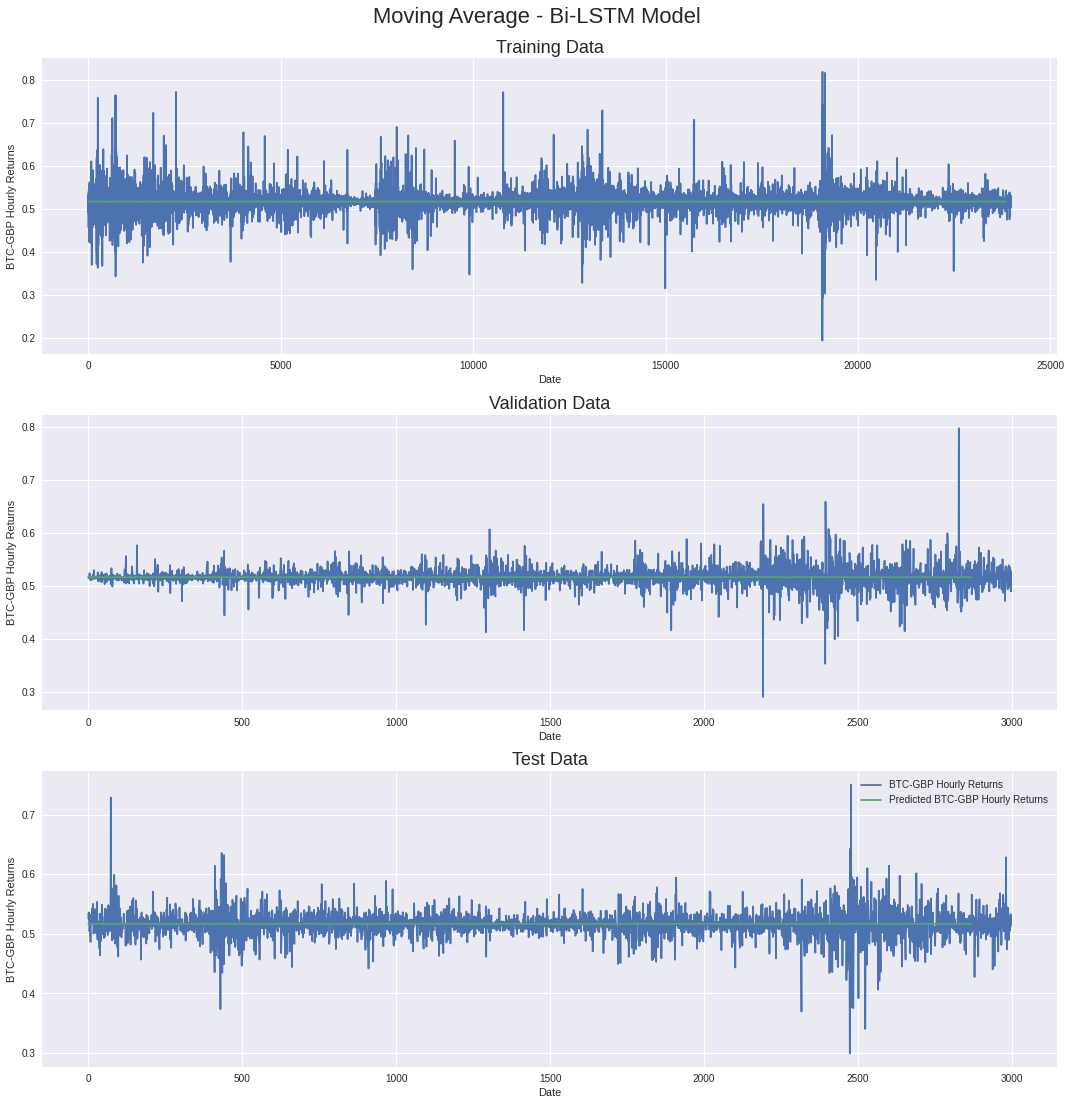

In [52]:
# display results
fig = plt.figure(figsize=(15,15))
st = fig.suptitle("Moving Average - Bi-LSTM Model", fontsize=22)
st.set_y(1.02)

# plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='BTC-GBP Hourly Returns')
ax11.plot(train_pred, label='Predicted BTC-GBP Hourly Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC-GBP Hourly Returns')

# plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='BTC-GBP Hourly Returns')
ax21.plot(val_pred, label='Predicted BTC-GBP Hourly Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('BTC-GBP Hourly Returns')

# plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='BTC-GBP Hourly Returns')
ax31.plot(test_pred, label='Predicted BTC-GBP Hourly Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('BTC-GBP Hourly Returns')
 
plt.tight_layout()
plt.legend(loc='best')

In [53]:
!ls

Bi-LSTM.hdf5  btc-gbp-3600.csv	CNN+Bi-LSTM.hdf5  MA-Bi-LSTM.hdf5  sample_data


In [54]:
from google.colab import files
files.download('/content/MA-Bi-LSTM.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Moving Average - CNN + Bi-LSTM model**

In [55]:
def create_model():
  in_seq = Input(shape=(seq_len, 5))

  x = Inception_A(in_seq, 32)
  x = Inception_A(x, 32)
  x = Inception_B(x, 32)
  x = Inception_B(x, 32)
  x = Inception_C(x, 32)
  x = Inception_C(x, 32)    
          
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])     
  return model

model = create_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 5)]     0                                            
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 128, 32)      160         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 128, 32)      128         conv1d_45[0][0]                  
__________________________________________________________________________________________________
re_lu_45 (ReLU)                 (None, 128, 32)      0           batch_normalization_45[0][0]     
____________________________________________________________________________________________

In [56]:
callback = tf.keras.callbacks.ModelCheckpoint('MA-CNN+Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

In [57]:
model.fit(X_train, y_train,
              batch_size=2048,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),)

Epoch 1/200
12/12 - 28s - loss: 0.0012 - mae: 0.0245 - mape: 4.7745 - val_loss: 6.3901e-04 - val_mae: 0.0186 - val_mape: 3.5601

Epoch 00001: val_loss improved from inf to 0.00064, saving model to MA-CNN+Bi-LSTM.hdf5
Epoch 2/200
12/12 - 4s - loss: 4.2411e-04 - mae: 0.0124 - mape: 2.4398 - val_loss: 6.6298e-04 - val_mae: 0.0192 - val_mape: 3.6697

Epoch 00002: val_loss did not improve from 0.00064
Epoch 3/200
12/12 - 4s - loss: 3.9511e-04 - mae: 0.0113 - mape: 2.2105 - val_loss: 5.9129e-04 - val_mae: 0.0173 - val_mape: 3.3283

Epoch 00003: val_loss improved from 0.00064 to 0.00059, saving model to MA-CNN+Bi-LSTM.hdf5
Epoch 4/200
12/12 - 4s - loss: 3.8885e-04 - mae: 0.0110 - mape: 2.1642 - val_loss: 5.8541e-04 - val_mae: 0.0172 - val_mape: 3.2997

Epoch 00004: val_loss improved from 0.00059 to 0.00059, saving model to MA-CNN+Bi-LSTM.hdf5
Epoch 5/200
12/12 - 4s - loss: 3.8698e-04 - mae: 0.0110 - mape: 2.1572 - val_loss: 5.6013e-04 - val_mae: 0.0165 - val_mape: 3.1729

Epoch 00005: val_los

In [58]:
model = tf.keras.models.load_model('/content/MA-CNN+Bi-LSTM.hdf5')

In [59]:
# calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

# print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Evaluation metrics
Training Data - Loss: 0.0004, MAE: 0.0110, MAPE: 2.1656
Validation Data - Loss: 0.0005, MAE: 0.0142, MAPE: 2.7771
Test Data - Loss: 0.0006, MAE: 0.0160, MAPE: 3.1578


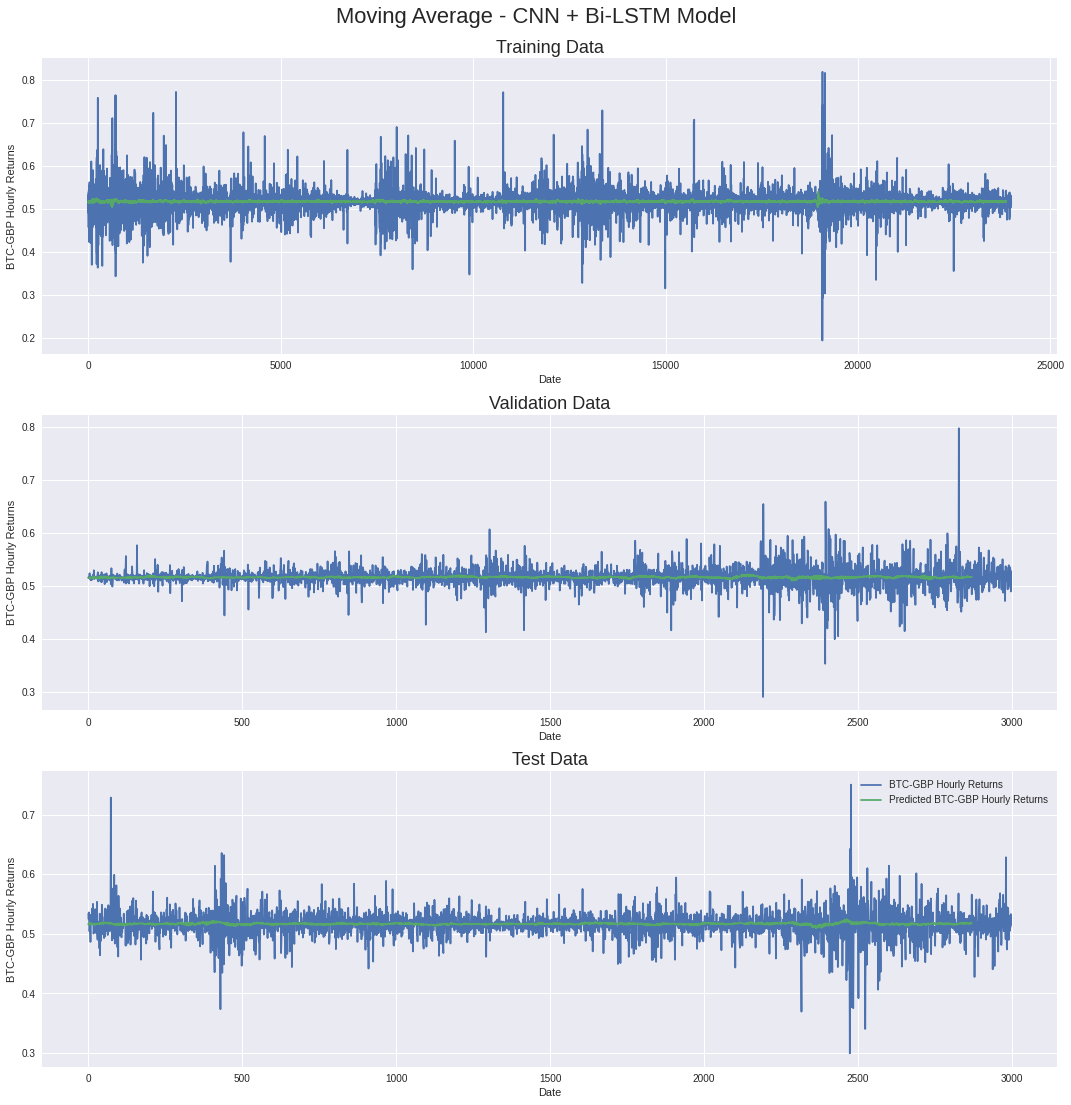

In [60]:
# display results
fig = plt.figure(figsize=(15,15))
st = fig.suptitle("Moving Average - CNN + Bi-LSTM Model", fontsize=22)
st.set_y(1.02)

# plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='BTC-GBP Hourly Returns')
ax11.plot(train_pred, label='Predicted BTC-GBP Hourly Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC-GBP Hourly Returns')

# plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='BTC-GBP Hourly Returns')
ax21.plot(val_pred, label='Predicted BTC-GBP Hourly Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('BTC-GBP Hourly Returns')

# plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='BTC-GBP Hourly Returns')
ax31.plot(test_pred, label='Predicted BTC-GBP Hourly Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('BTC-GBP Hourly Returns')
 
plt.tight_layout()
plt.legend(loc='best')

In [61]:
!ls

Bi-LSTM.hdf5	  CNN+Bi-LSTM.hdf5  MA-CNN+Bi-LSTM.hdf5
btc-gbp-3600.csv  MA-Bi-LSTM.hdf5   sample_data


In [62]:
from google.colab import files
files.download('/content/MA-CNN+Bi-LSTM.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
test_data

array([[0.524426  , 0.52459279, 0.52917856, 0.53399637, 0.02329791],
       [0.53308733, 0.53686912, 0.52555819, 0.52450624, 0.02202209],
       [0.52521935, 0.52089719, 0.52601696, 0.53587756, 0.01333498],
       ...,
       [0.51052726, 0.51171653, 0.51319974, 0.51141573, 0.00522526],
       [0.51075788, 0.52378467, 0.51810648, 0.53299212, 0.02194888],
       [0.5345369 , 0.51069095, 0.52675579, 0.51533913, 0.00545267]])

In [66]:
test_pred

array([[0.5164321 ],
       [0.5151446 ],
       [0.51780033],
       ...,
       [0.519178  ],
       [0.5175266 ],
       [0.51767564]], dtype=float32)